<a href="https://colab.research.google.com/github/haosulab/SAPIEN-tutorial/blob/master/basics/2_create_actors.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Some core features of SAPIEN are not available on Colab, including the interactive viewer and ray-tracing functionalities. You need to run SAPIEN locally for full features. You can also find the latest SAPIEN tutorial at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/latest/index.html).

# Basics Tutorial 2: Create Actors

SAPIEN simulates rigid body dynamics. In SAPIEN, **actor** is an alias of rigid body.

In this tutorial, you will learn the following:

- Create `Actor` using primitives (box, sphere, capsule)
- Use `Pose` to set the pose of an actor

## Preparation

> Note: you need GPU runtime to run the notebook.

In [2]:
# 安装 Vulkan 加载器和基础库
!apt-get update && apt-get install -y libvulkan1
# 某些情况下需要明确安装 NVIDIA 的 Vulkan 支持
!apt-get install -y mesa-vulkan-drivers

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [357 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.2 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,787 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu

In [3]:
%pip install sapien

import sapien.core as sapien
import numpy as np
import os
from PIL import Image

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

Before we start, let's set up the simulation engine and renderer, and add the ground to our scene.

In [5]:
# Set up simulation engine and renderer
scene = sapien.Scene()
scene.set_timestep(1 / 100.0)
scene.add_ground(altitude=0)  # The ground is in fact a special actor.

## Create an actor by a single primitive

The primitives supported by SAPIEN include box, sphere and capsule. Let's see an example about how to create a box.

In [13]:
def create_box(
        scene: sapien.Scene,
        pose: sapien.Pose,
        half_size,
        color=None,  # 这里的 color 参数我们暂时不用，或者用来创建材质
        name='',
) -> sapien.Entity:
    half_size = np.array(half_size)
    builder = scene.create_actor_builder()
    builder.add_box_collision(half_size=half_size)

    # 修正：删除 color=color 参数
    builder.add_box_visual(half_size=half_size)

    box = builder.build(name=name)
    box.set_pose(pose)
    return box

`Actor` (or rigid body) is created through `ActorBuilder` in SAPIEN. An actor consists of both collision shapes (used for physical simulation) and visual shapes (used for rendering). You can call `add_box_collision` and `add_box_visual` to add collision and visual shapes of an box respectively.

> Note: Collision shapes do not necessarily correspond to visual shapes. For example, you might have a simple collision shape for fast simulation, but a complicated visual shape for realistic rendering.

Then, you might create a box as follows:

In [14]:
box = create_box(
    scene,
    sapien.Pose(p=[0, 0, 1.0 + 0.05]),
    half_size=[0.05, 0.05, 0.05],
    name='box',
)

> `sapien.Pose` takes two parameters, `p` and `q`, to construct. The `p` parameter is a three-dimensional translation vector that specifies that position of the actor, and `q` is a four-dimensional quarternion that specifies the orientation of the actor.

Similarly, we can create a sphere and a capsule in our scene.

In [17]:
def create_sphere(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        color=None,
        name='',
) -> sapien.Entity:
    builder = scene.create_actor_builder()
    builder.add_sphere_collision(radius=radius)

    # 适配 3.0：去掉 color=color，或者改用 material
    builder.add_sphere_visual(radius=radius)

    sphere = builder.build(name=name)
    sphere.set_pose(pose)
    return sphere

def create_capsule(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        half_length,
        color=None,
        name='',
) -> sapien.Entity: # 注意：3.0 中统一返回 Entity
    builder = scene.create_actor_builder()
    builder.add_capsule_collision(radius=radius, half_length=half_length)

    # 适配 3.0：去掉 color=color
    builder.add_capsule_visual(radius=radius, half_length=half_length)

    capsule = builder.build(name=name)
    capsule.set_pose(pose)
    return capsule

In [18]:
sphere = create_sphere(
    scene,
    sapien.Pose(p=[0, -0.2, 1.0 + 0.05]),
    radius=0.05,
    name='sphere',
)

capsule = create_capsule(
    scene,
    sapien.Pose(p=[0, 0.2, 1.0 + 0.05]),
    radius=0.05,
    half_length=0.05,
    name='capsule',
)

## Create an actor by multiple primitives

Next, we show an example to create an actor (table) by multiple boxes (a tabletop with four legs).

In [20]:
def create_table(
        scene: sapien.Scene,
        pose: sapien.Pose,
        size,
        height,
        thickness=0.1,
        color=None,
        name='table',
) -> sapien.Entity:
    """Create a table (a collection of collision and visual shapes)."""
    builder = scene.create_actor_builder()

    # Tabletop
    tabletop_pose = sapien.Pose([0., 0., -thickness / 2])  # Make the top surface's z equal to 0
    tabletop_half_size = [size / 2, size / 2, thickness / 2]
    builder.add_box_collision(pose=tabletop_pose, half_size=tabletop_half_size)
    builder.add_box_visual(pose=tabletop_pose, half_size=tabletop_half_size)

    # Table legs (x4)
    for i in [-1, 1]:
        for j in [-1, 1]:
            x = i * (size - thickness) / 2
            y = j * (size - thickness) / 2
            table_leg_pose = sapien.Pose([x, y, -height / 2])
            table_leg_half_size = [thickness / 2, thickness / 2, height / 2]
            builder.add_box_collision(pose=table_leg_pose, half_size=table_leg_half_size)
            builder.add_box_visual(pose=table_leg_pose, half_size=table_leg_half_size)

    table = builder.build(name=name)
    table.set_pose(pose)
    return table

In [21]:
table = create_table(
    scene,
    sapien.Pose(p=[0, 0, 1.0]),
    size=1.0,
    height=1.0,
)

We can call `add_box_collision(pose=Pose(...), ...)` to set the pose of a collision shape in the actor frame. Similarly, we can call `add_box_visual(pose=Pose(...), ...)` for a visual shape. Note that `table.set_pose(pose)` sets the pose of the actor in the **world frame**.

## Create an actor by a mesh file

In SAPIEN, you can also create an actor from the mesh file. The following code will import the banana mesh we prepared for you:

In [24]:
if IN_COLAB:
    !gdown -q 1O8aFtLqJ12XW0fuEEpeHMrj_62p-0Il8
    !unzip -o -q banana.zip
    assets_dir = "."
else:
    assets_dir = "../assets"

builder = scene.create_actor_builder()

# SAPIEN 3.0 最新适配写法：
# 使用 add_convex_collision_from_file 或 add_nonconvex_collision_from_file
# 对于香蕉这种不规则物体，通常使用凸包（Convex）分解
builder.add_convex_collision_from_file(
    filename=os.path.join(assets_dir, "banana/collision_meshes/collision.obj")
)

# 视觉部分通常还是这个接口，但如果报错，可以尝试去掉 material 参数
builder.add_visual_from_file(
    filename=os.path.join(assets_dir, "banana/visual_meshes/visual.dae")
)

mesh = builder.build(name='mesh')
mesh.set_pose(sapien.Pose(p=[-0.3, 0, 1.0 + 0.05]))

## Visualization

Let's visualize the scene as we did before:

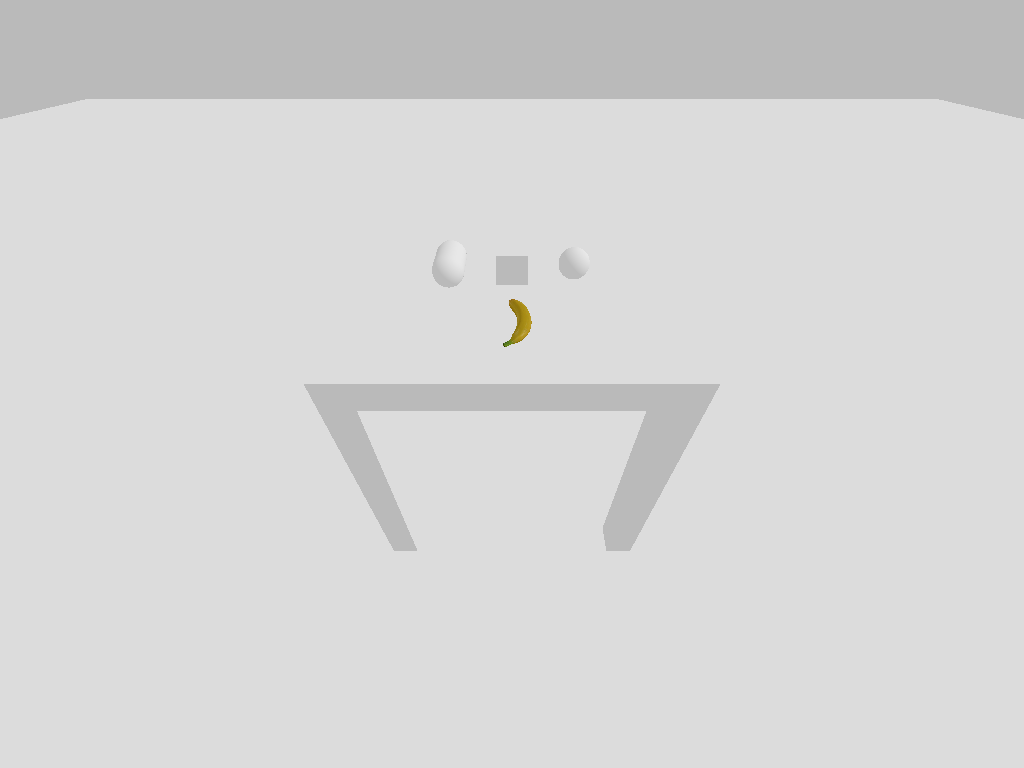

In [26]:
# 1. 设置光照
scene.set_ambient_light([0.5, 0.5, 0.5])
scene.add_directional_light([0, 1, -1], [0.5, 0.5, 0.5])

# 2. 添加摄像头
camera = scene.add_camera(name='camera', width=1024, height=768, fovy=1.57, near=0.1, far=100)
# SAPIEN 3.0 建议使用 set_entity_pose
camera.set_entity_pose(sapien.Pose([-1.15147, 0, 1.65147], [0.92388, 0, 0.382683, 0]))

# 3. 渲染
scene.step()
scene.update_render()
camera.take_picture()

# --- 重点：SAPIEN 3.0 获取图像的新写法 ---
# 'Color' 返回的是 [H, W, 4] 的 float32 数组 (RGBA)
rgba = camera.get_picture('Color')

# 4. 显示图片
rgb = rgba[..., :3] # 只要 RGB
# 将 0-1 的浮点数转为 0-255 的整数
img = Image.fromarray((rgb * 255).astype(np.uint8))
img.show() # 在 Colab 中直接写 img 也会显示
img

## Remove an actor

After an actor is built with `actor = builder.build()`, You can call `scene.remove_actor(actor)` to remove it. Using a removed actor will result in undefined behavior (usually a crash).

方块已经不在场景中，无需重复移除


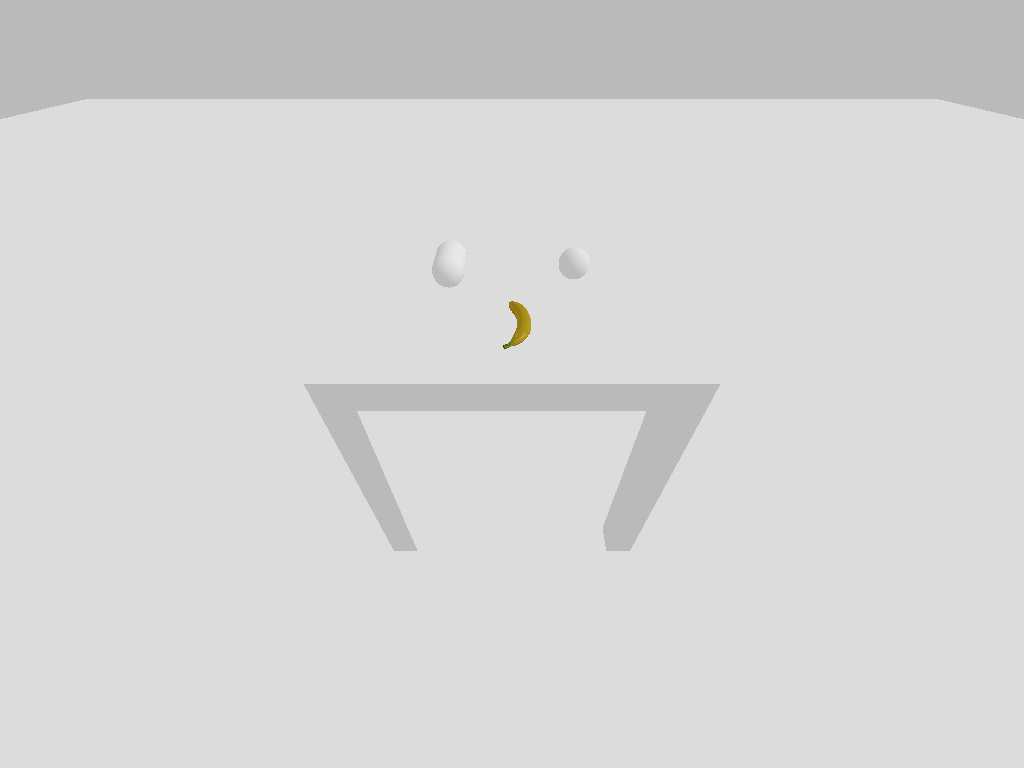

In [29]:
try:
    scene.remove_actor(box)
    print("成功移除方块")
except RuntimeError:
    print("方块已经不在场景中，无需重复移除")

# 继续执行后续渲染步骤
scene.step()
scene.update_render()
camera.take_picture()
rgba = camera.get_picture('Color')
rgb = rgba[..., :3]
Image.fromarray((rgb*255).astype(np.uint8))